<a href="https://colab.research.google.com/github/Mohand995/Dified_task/blob/main/Digified_Task_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install  ar_wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
from tensorflow.keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer 
from tqdm.auto import tqdm
import re
from keras import layers,models
import pickle
import nltk
from sklearn.model_selection import train_test_split
nltk.download('punkt')
from sklearn.linear_model import *
from sklearn.ensemble import *
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_curve,auc,RocCurveDisplay,classification_report
from ar_wordcloud import ArabicWordCloud
awc = ArabicWordCloud(background_color="white")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Read_Data**

In [3]:
Data=pd.read_csv("/content/Names_Verification_ds_.csv")

In [4]:
Data=Data[['names','labels']]

In [5]:
Data.sample(20)

,names,labels
150284,رةكشي مكير بدلاهلع,0
109811,رظين مهفي& كرب,0
160312,ةكبار ترفأ لبأغ,0
183835,اررأس انور باوت@,0
145915,رقاط# بطاح@ ثكمأ6,0
111758,اجورم لهسي سأير,0
182600,ماهجدة حماط2 نعو,0
153169,مسة امحل تيق#,0
52487,سيلين حارب شيبة,1
172799,دهوع قبط* دعوس,0


**EDA**

In [6]:
Data.labels.value_counts()

1    100000
0    100000
Name: labels, dtype: int64

In [7]:
Data.isna().any()

names     False
labels    False
dtype: bool

In [8]:
Data.duplicated().any()

True

In [9]:
Data.drop_duplicates(inplace=True)

In [10]:
Data.labels.value_counts()

0    100000
1     99995
Name: labels, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'count for each label')

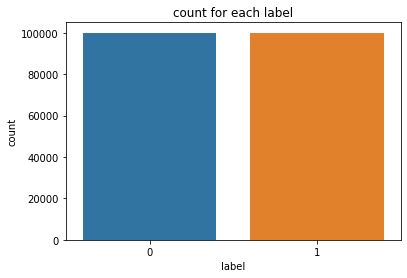

In [11]:
sns.countplot(Data.labels) ; 
plt.xlabel("label")
plt.ylabel("count")
plt.title("count for each label")

In [12]:
names=Data.names.tolist()
str_names=' '.join(names)

In [13]:
wc = awc.from_text(str_names)

Text(0.5, 1.0, 'word_colud_of_names')

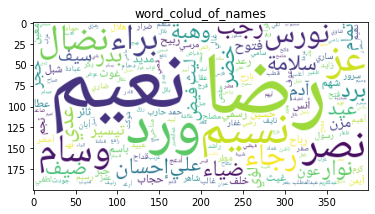

In [14]:
plt.imshow(wc)
plt.title("word_colud_of_names")

**Feature_Extraction + Modeling**

let's start with the most naive and simple baseline modeling 

**Split_Data**


In [15]:
target=Data['labels']
x_train_, x_test_ ,y_train_ ,y_test_ = train_test_split(Data['names'],target,test_size=0.2,stratify=target,random_state=42)

In [16]:
x_train=x_train_[:50000] 
y_train=y_train_[:50000]
x_test=x_test_[:10000]
y_test=y_test_[:10000]

**TFIDF+Random_Forrest**

In [17]:
tfidf_vect=TfidfVectorizer(max_features=10000,ngram_range=(1,3))

In [18]:
clf2=RandomForestClassifier()
pipe2=make_pipeline(tfidf_vect,clf2)
pipe2.fit(x_train,y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('randomforestclassifier', RandomForestClassifier())])

In [19]:
pred=pipe2.predict(x_test)

In [20]:
accuracy_score(y_test,pred)

0.9807

In [21]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4930
           1       0.96      1.00      0.98      5070

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [22]:
len(pred)

10000

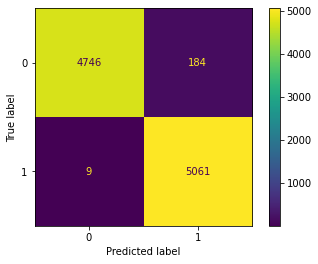

In [23]:
cm = confusion_matrix(y_test, pred, labels=pipe2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe2.classes_)
disp.plot()
plt.show()

**Run some Sanity Checks**

In [24]:
def Test_Model(model):
  decode_preds={0:"Fake",1:"Correct"}
  random_sample=x_test.sample(1,ignore_index=True)[0]
  prediction=model.predict(np.array([random_sample]))
  print("the name is {}".format(random_sample))
  print("Model classify it as  {}".format(decode_preds[prediction[0]]))

In [25]:
Test_Model(pipe2)

the name is يمعن بيغل2 عكاةش
Model classify it as  Fake


In [96]:
name="باسمم وحةد السد”"
point=np.array([name])
pipe2.predict(point)[0]

0

In [99]:
name="ياسر محمد محمود"
point=np.array([name])
pipe2.predict(point)[0]

1

In [28]:
pickle.dump(pipe2,open("Random_forrest_pipeline_",'wb'))

**Try Deep NN**

In [19]:
tfidf_vect.fit(x_train,y_train)

TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

In [20]:
X_train_count=tfidf_vect.transform(x_train).toarray()
X_test_count=tfidf_vect.transform(x_test).toarray()

In [21]:
model_1=models.Sequential()
model_1.add(layers.Dense(128,activation='relu',input_shape=(10000,)))
model_1.add(layers.Dense(64,activation='relu'))
model_1.add(layers.Dense(32,activation='relu'))
model_1.add(layers.Dense(1,activation='sigmoid'))
model_1.compile(optimizer= RMSprop(lr=0.0001),
              loss= keras.losses.binary_crossentropy,
              metrics= [keras.metrics.binary_accuracy])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [22]:
model_1.fit(X_train_count,y_train,epochs=10,validation_data=(X_test_count,y_test))

Epoch 1/10
1563/1563 [==============================] - 15s 8ms/step - loss: 0.4282 - binary_accuracy: 0.8773 - val_loss: 0.0574 - val_binary_accuracy: 0.9836
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0254 - binary_accuracy: 0.9928 - val_loss: 0.0293 - val_binary_accuracy: 0.9918
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0155 - binary_accuracy: 0.9956 - val_loss: 0.0341 - val_binary_accuracy: 0.9906
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0127 - binary_accuracy: 0.9964 - val_loss: 0.0234 - val_binary_accuracy: 0.9940
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0107 - binary_accuracy: 0.9972 - val_loss: 0.0232 - val_binary_accuracy: 0.9937
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0091 - binary_accuracy: 0.9978 - val_loss: 0.0222 - val_binary_accuracy: 0.9940
Epoch 7/10
1563/1563 [=============================

**test_model**

In [49]:
test_set=x_test_[10000:20000]
x_test_vectorized=tfidf_vect.transform(test_set).toarray()
model_1.evaluate(x_test_vectorized,y_test_[10000:20000])

313/313 [==============================] - 1s 4ms/step - loss: 0.0120 - binary_accuracy: 0.9978


[0.012042145244777203, 0.9977999925613403]

In [26]:
def test_dl_model(text):
    point=np.array([text])
    x=tfidf_vect.transform(point).toarray()
    prob=model_1.predict(x)[0][0]
    if prob>0.5:
      print("model classify it as correct")
    else:
      print("model classify it as fake")

In [41]:
name=x_test_.sample(1,ignore_index=True)[0]
print(name)
test_dl_model(name)

عسدا ولغزل سمعاد
1/1 [==============================] - 0s 14ms/step
model classify it as fake


In [83]:
model_1.save("DL_classifier.h5")